In [1]:
import eztao
import matplotlib as mpl
%matplotlib inline
import os
mpl.rc_file(os.path.join(eztao.__path__[0], "viz/eztao.rc"))
import numpy as np
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from eztao.carma import DRW_term
from eztao.ts import gpSimFull

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# lets generate some fake luminosity function

def sample_log_slope_in_x(n_samples, xmin=45., xmax=46., alpha=-1.0):
    """
    Draw samples on [xmin, xmax] with pdf p(x) ∝ 10^(alpha * x).
    Negative alpha => fewer samples at higher x.
    """
    u = np.random.random(n_samples)
    a = 10**(alpha * xmin)
    b = 10**(alpha * xmax)
    return (1.0 / alpha) * np.log10(a + u * (b - a))


# Example: slope -1 between 45 and 46
samples = sample_log_slope_in_x(200000, xmin=45., xmax=46., alpha=-1.0)

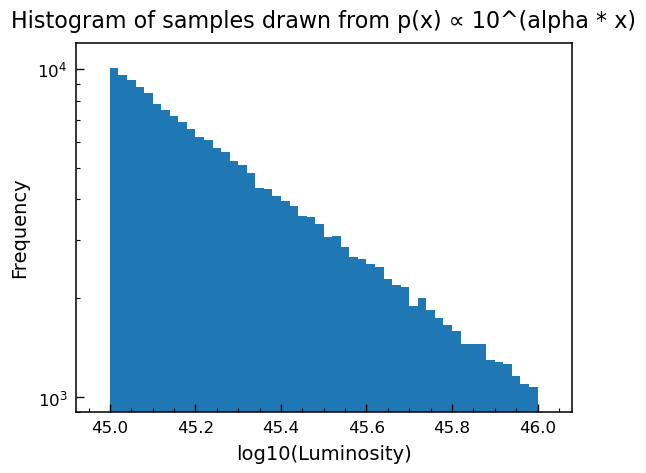

In [3]:
# we look that it is indeed following power law distribution

plt.hist(samples, bins=50)
plt.xlabel("log10(Luminosity)")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Histogram of samples drawn from p(x) ∝ 10^(alpha * x)")
plt.show()

<ErrorbarContainer object of 3 artists>

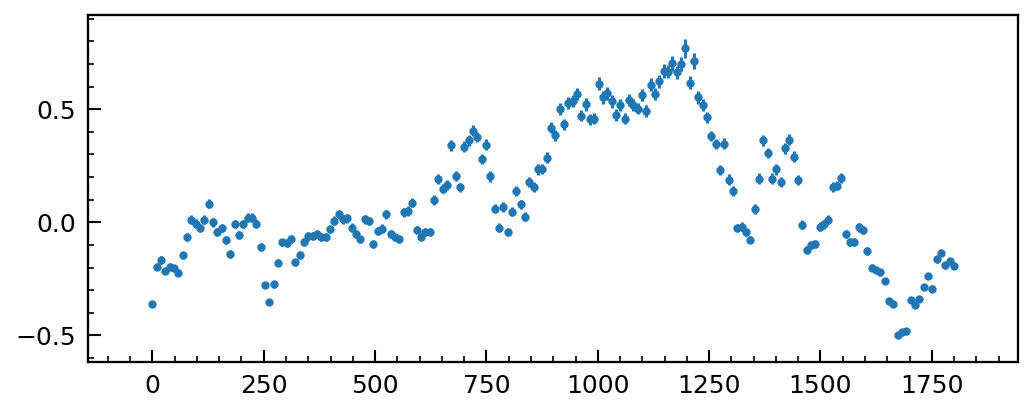

In [4]:
# first, lets create a DRW kernel and simulate a light curve

# define a DRW kernel & and simulate a process
amp = 0.2
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))


t, y, yerr = gpSimFull(DRW_kernel, 10, 360*5, 37*5+1)

# now, plot it
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')

In [5]:
# now, lets create many light curves by adding the above simulateded light curves to each of the samples

samples_2 = np.zeros([len(samples), 37*5+1])

for i in tqdm(range(len(samples))):
    t, y, yerr = gpSimFull(DRW_kernel, 10, 360*5, 37*5+1)
    samples_2[i] = y + samples[i]

100%|██████████| 200000/200000 [00:37<00:00, 5354.96it/s]


In [6]:
# select indices where luminosity is between 45.45 and 45.55, i.e., in the middle of the range
idx = np.where((samples_2[:, 1] >= 45.45) & (samples_2[:, 1] <= 45.55))[0]

# for these indices, compute the mean difference between the starting point (column 0) and all other points

# samples_2: shape (N, M)
N, M = samples_2.shape

diffs = []   # will store mean differences

for j in range(1, M):
    diff = samples_2[idx][:, 0] - samples_2[idx][:, j]
    diffs.append(np.mean(diff))

diffs = np.array(diffs)

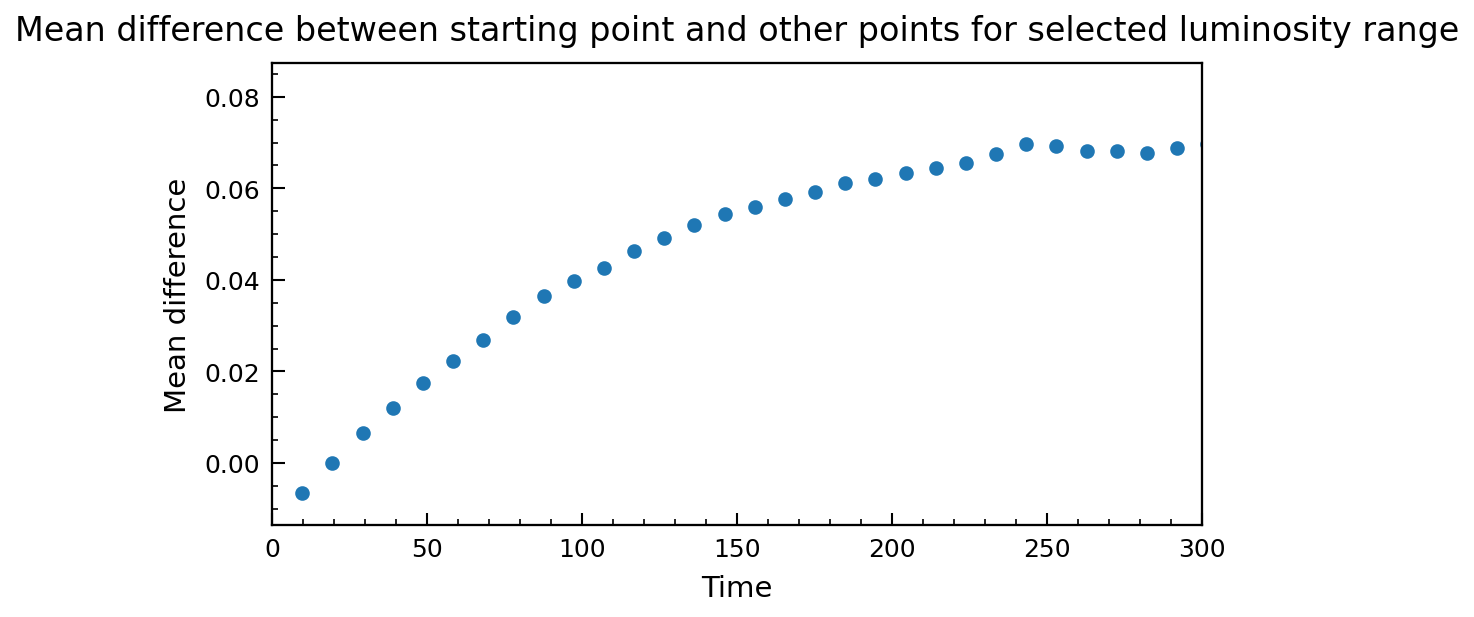

In [7]:
# This shows that on average, the luminosity tends to return to the starting point over time

plt.figure(figsize=(8,4), dpi=150)
plt.scatter(t[1:], diffs)
plt.xlabel("Time")
plt.ylabel("Mean difference")
plt.title("Mean difference between starting point and other points for selected luminosity range")
plt.xlim(0, 300)
plt.show()

In [8]:
#  Now, we compute directional structure functions for brightening and dimming, for that subset of light curves



def structure_function_directional(t, mag, lag_bins, mode="brightening"):
    """
    Directional structure function: SF_brightening or SF_dimming.

    Parameters
    ----------
    t : array_like, shape (N,)
        Observation times (e.g. days). Can be unsorted; will be sorted internally.
    mag : array_like, shape (N,)
        Magnitudes corresponding to t.
    lag_bins : array_like, shape (M+1,)
        Bin edges in time lag.
    mode : {"brightening", "dimming"}
        - "brightening": use only pairs where the later point is brighter
                         (m_later < m_earlier).
        - "dimming":    use only pairs where the later point is dimmer
                         (m_later > m_earlier).

    Returns
    -------
    lag_centers : ndarray, shape (M,)
        Centers of the lag bins.
    sf : ndarray, shape (M,)
        Directional structure function SF(τ) for each lag bin.
        (NaN if no qualifying pairs fall in that bin.)
    """
    t = np.asarray(t, dtype=float)
    mag = np.asarray(mag, dtype=float)
    lag_bins = np.asarray(lag_bins, dtype=float)

    if t.shape != mag.shape:
        raise ValueError("t and mag must have the same shape")

    # Sort by time
    order = np.argsort(t)
    t = t[order]
    mag = mag[order]

    N = len(t)

    # Use only pairs with j > i so t_j is strictly later than t_i
    i_idx, j_idx = np.triu_indices(N, k=1)

    dt = t[j_idx] - t[i_idx]      # > 0, time lags
    dm = mag[j_idx] - mag[i_idx]  # later - earlier

    # Directional selection
    if mode == "brightening":
        # later magnitude smaller than earlier -> brightening in flux
        dir_mask = dm < 0.0
    elif mode == "dimming":
        # later magnitude larger than earlier -> dimming in flux
        dir_mask = dm > 0.0
    else:
        raise ValueError("mode must be 'brightening' or 'dimming'")

    dt = dt[dir_mask]
    dm = dm[dir_mask]

    # Absolute magnitude difference
    delta_m = np.abs(dm)

    # Bin by time lag
    bin_idx = np.digitize(dt, lag_bins) - 1
    n_bins = len(lag_bins) - 1

    sf = np.full(n_bins, np.nan)

    for k in range(n_bins):
        mask = bin_idx == k
        if not np.any(mask):
            continue

        dm_k = delta_m[mask]

        # SF(τ) = 0.5 * <(Δm)^2>; change this line if you want a different definition
        sf[k] = 0.5 * np.mean(dm_k**2)

    lag_centers = 0.5 * (lag_bins[:-1] + lag_bins[1:])
    return lag_centers, sf

In [9]:

def structure_function(
    t,
    mag,
    lag_bins,
    use_half_delta_m2=False,
):
    """
    Compute the (first-order) structure function SF(τ) of a light curve.

    Parameters
    ----------
    t : array_like, shape (N,)
        Observation times (e.g. in days). Can be unsorted and irregular.
    mag : array_like, shape (N,)
        Magnitudes at those times.
    lag_bins : array_like, shape (M+1,)
        Bin edges in time lag (same units as t). For example:
        np.logspace(-2, 2, 20) for 0.01–100 days.
    use_half_delta_m2 : bool, optional
        If False (default): SF = Var(Δm) in each lag bin.
        If True:  SF = 0.5 * <(Δm)^2> in each lag bin
                  (a common definition in astronomy).

    Returns
    -------
    lag_centers : ndarray, shape (M,)
        Centers of the lag bins.
    sf : ndarray, shape (M,)
        Structure function values for each lag bin. NaN if no pairs
        fall into that bin.

    Notes
    -----
    Complexity is O(N^2); fine for N ~ few 10^3. For very large N,
    you’ll want a more optimized approach (e.g. sub-sampling or
    binning in time first).
    """
    t = np.asarray(t, dtype=float)
    mag = np.asarray(mag, dtype=float)
    lag_bins = np.asarray(lag_bins, dtype=float)

    if t.shape != mag.shape:
        raise ValueError("t and mag must have the same shape")

    # Sort by time (not strictly necessary for the math, but nice to have)
    order = np.argsort(t)
    t = t[order]
    mag = mag[order]

    # All pairwise time differences and magnitude differences
    dt = t[:, None] - t[None, :]           # shape (N, N)
    dm = mag[:, None] - mag[None, :]       # shape (N, N)

    # Use only one triangle (j < k) to avoid double-counting and dt = 0
    iu = np.triu_indices(len(t), k=1)
    dt = dt[iu]
    dm = dm[iu]

    # Absolute time lags
    lag = np.abs(dt)

    # Assign each pair to a lag bin
    bin_idx = np.digitize(lag, lag_bins) - 1  # now in [0, M-1]
    n_bins = len(lag_bins) - 1

    sf = np.full(n_bins, np.nan)

    for i in range(n_bins):
        mask = bin_idx == i
        if not np.any(mask):
            continue

        dm_i = dm[mask]

        if use_half_delta_m2:
            # SF(τ) = 0.5 * <(Δm)^2>
            sf[i] = 0.5 * np.mean(dm_i**2)
        else:
            # SF(τ) = Var(Δm)
            # (ddof=0 for population variance)
            sf[i] = np.var(dm_i, ddof=0)

    # Bin centers
    lag_centers = 0.5 * (lag_bins[:-1] + lag_bins[1:])
    return lag_centers, sf



In [10]:
import numpy as np

def average_directional_structure_function(samples, t, lag_bins, mode="brightening"):
    """
    Compute an average directional structure function (SF_brightening or SF_dimming)
    over a population of light curves.

    Parameters
    ----------
    samples : ndarray, shape (N_lc, N_times)
        Array of light curves, one per row.
    t : ndarray, shape (N_times,)
        Observation times (same for all light curves).
    lag_bins : ndarray
        Bin edges for the structure function.
    mode : {"brightening", "dimming"}
        Which directional SF to compute:
        - "brightening": only pairs with later mag < earlier mag
        - "dimming":    only pairs with later mag > earlier mag

    Returns
    -------
    lag_centers : ndarray, shape (M,)
        Centers of lag bins.
    sf_mean : ndarray, shape (M,)
        Mean directional SF across all light curves.
    sf_std : ndarray, shape (M,)
        Standard deviation across the population.
    """
    n_lc = samples.shape[0]
    sf_list = []

    for i in range(n_lc):
        _, sf = structure_function_directional(t, samples[i], lag_bins, mode=mode)
        sf_list.append(sf)

    sf_array = np.vstack(sf_list)  # shape (N_lc, M)

    sf_mean = np.nanmean(sf_array, axis=0)
    
    # Number of non-NaN values per bin
    N_eff = np.sum(~np.isnan(sf_array), axis=0)
    
    sf_std  = np.nanstd(sf_array, axis=0)
    
    # Standard error of the mean (uncertainty of the mean)
    sf_sem = sf_std / np.sqrt(N_eff)

    

    lag_centers = 0.5 * (lag_bins[:-1] + lag_bins[1:])
    return lag_centers, sf_mean, sf_sem

In [11]:
def average_total_structure_function(samples, t, lag_bins):
    sf_list = []
    for i in range(samples.shape[0]):
        _, sf = structure_function(t, samples[i], lag_bins)
        sf_list.append(sf)

    sf_array = np.vstack(sf_list)
    sf_mean = np.nanmean(sf_array, axis=0)

    # Standard error of mean (if needed)
    N_eff = np.sum(~np.isnan(sf_array), axis=0)
    sf_std = np.nanstd(sf_array, axis=0)
    sf_sem = sf_std / np.sqrt(N_eff)

    return 0.5 * (lag_bins[:-1] + lag_bins[1:]), sf_mean, sf_sem

In [12]:
def beta_structure_function(samples, t, lag_bins):
    # Brightening SF
    lag_c, sf_bright, _ = average_directional_structure_function(
        samples, t, lag_bins, mode="brightening"
    )

    # Dimming SF
    _, sf_dim, _ = average_directional_structure_function(
        samples, t, lag_bins, mode="dimming"
    )

    # Total SF (non-directional)
    _, sf_tot, _ = average_total_structure_function(
        samples, t, lag_bins
    )

    # Avoid division by zero
    safe = sf_tot != 0
    beta = np.full_like(sf_tot, np.nan, dtype=float)
    beta[safe] = (sf_bright[safe] - sf_dim[safe]) / sf_tot[safe]

    return lag_c, beta, sf_bright, sf_dim, sf_tot

In [13]:
lag_bins = np.linspace(10, 300, 20)


# Average brightening SF over population
lag_centers, sf_bright_mean, sf_bright_std = average_directional_structure_function(
    samples_2[idx], t, lag_bins, mode="brightening"
)

# Average dimming SF over population
lag_centers, sf_dim_mean, sf_dim_std = average_directional_structure_function(
    samples_2[idx], t, lag_bins, mode="dimming"
)
# Average total SF over population
lag_centers, sf_tot_mean, sf_tot_std = average_total_structure_function(
    samples_2[idx], t, lag_bins
)

lag_c, beta, sf_b, sf_d, sf_t = beta_structure_function(samples_2[idx], t, lag_bins)

print("Lag centers:", lag_c)
print("Beta:", beta)

Lag centers: [ 17.63157895  32.89473684  48.15789474  63.42105263  78.68421053
  93.94736842 109.21052632 124.47368421 139.73684211 155.
 170.26315789 185.52631579 200.78947368 216.05263158 231.31578947
 246.57894737 261.84210526 277.10526316 292.36842105]
Beta: [0.00516947 0.00700362 0.00830794 0.00925054 0.00982252 0.01017299
 0.01110749 0.01164978 0.01196375 0.01227901 0.01270393 0.01299734
 0.01357123 0.01449776 0.01464715 0.01536832 0.01668792 0.01777834
 0.01930867]


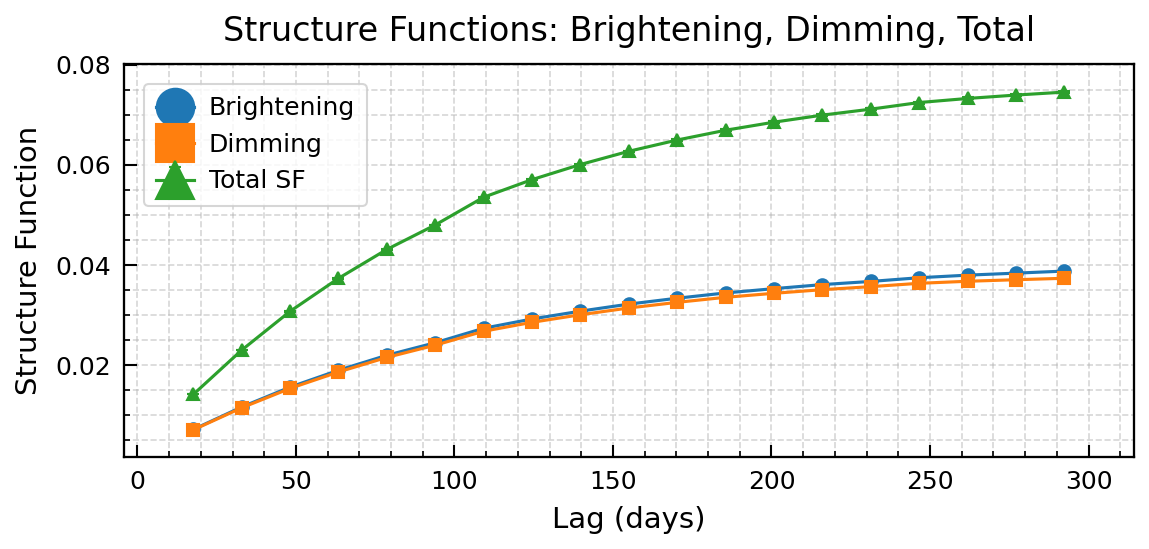

In [14]:
plt.figure(figsize=(8,4), dpi=150)

# Brightening SF
plt.errorbar(
    lag_centers, sf_bright_mean, yerr=sf_bright_std,
    fmt='o-', capsize=3, label="Brightening"
)

# Dimming SF
plt.errorbar(
    lag_centers, sf_dim_mean, yerr=sf_dim_std,
    fmt='s-', capsize=3, label="Dimming"
)

# Total SF (non-directional)
plt.errorbar(
    lag_centers, sf_tot_mean, yerr=sf_tot_std,
    fmt='^-', capsize=3, label="Total SF"
)


plt.xlabel("Lag (days)")
plt.ylabel("Structure Function")
plt.title("Structure Functions: Brightening, Dimming, Total")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

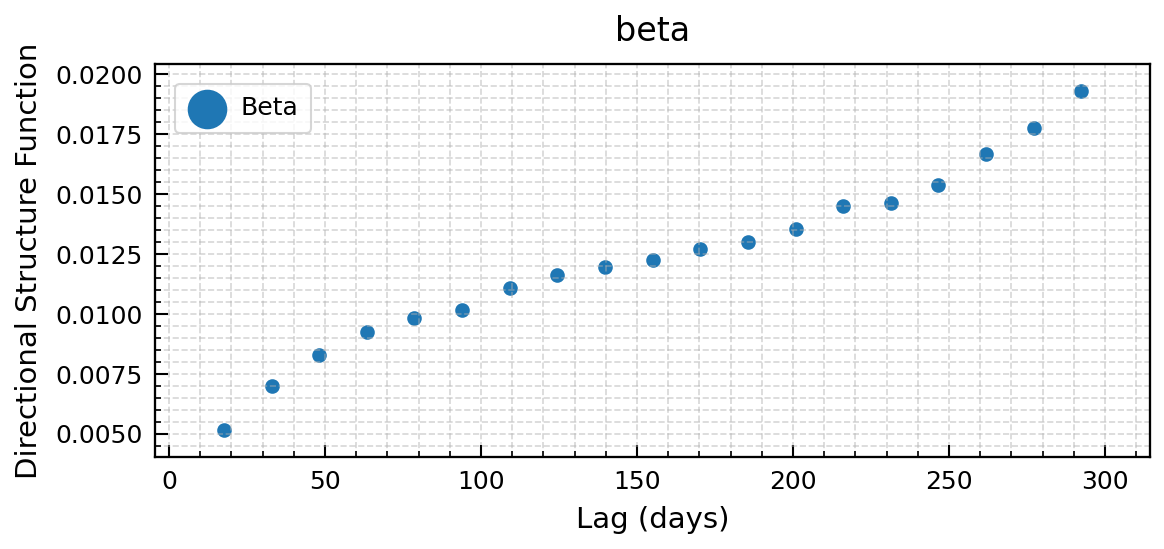

In [15]:
# Is this measurable?

plt.figure(figsize=(8,4), dpi=150)
plt.scatter(lag_c, beta, label="Beta")

plt.legend()
plt.xlabel("Lag (days)")
plt.ylabel("Directional Structure Function")
plt.title("beta")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()